In [68]:
%run '0.0_init_configuration.ipynb'

In [69]:
# Importando activo de yfinance
activo = 'BTC-USD'
df = yf.Ticker(activo)
df = df.history(start='2018-01-01', end='2024-12-09')

**Utilizaremos las EMA 11 y 17 testeada previamente**

In [70]:
# Cálculo de EMA
df['EMA_11'] = ta.EMA(df['Close'], timeperiod=11)
df['EMA_17'] = ta.EMA(df['Close'], timeperiod=17)

In [71]:
# Método de tendencias
df['Signal'] = 0

df.loc[df['EMA_11'] > df['EMA_17'], 'Signal'] = 1 # Compra
df.loc[df['EMA_11'] < df['EMA_17'], 'Signal'] = -1 # venta

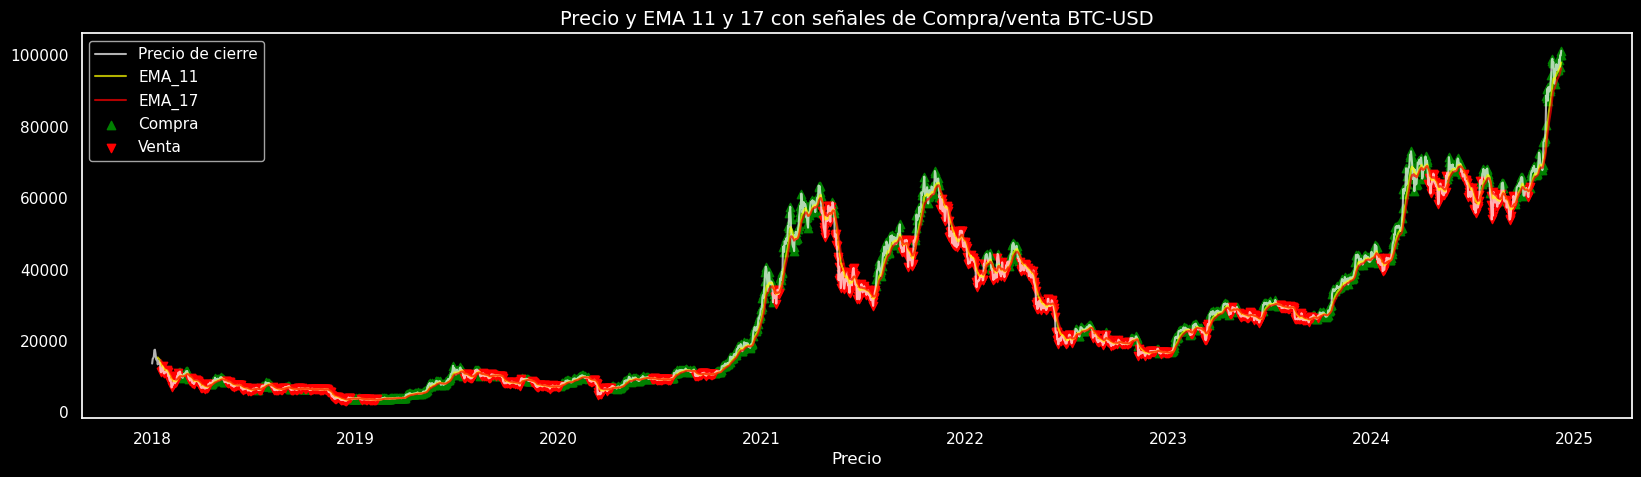

In [72]:
# Gráfico de compra y venta.ACOS
plt.plot(df.index, df['Close'], label='Precio de cierre', color='white', alpha=0.7)
plt.plot(df.index, df['EMA_11'], label='EMA_11', color='yellow', alpha=0.7)
plt.plot(df.index, df['EMA_17'], label='EMA_17', color='red', alpha=0.7)

plt.scatter(df.index[df['Signal'] == 1], df['Close'][df['Signal'] == 1],
             marker='^', color='green', label='Compra', alpha=1)
plt.scatter(df.index[df['Signal'] == -1], df['Close'][df['Signal'] == -1], 
            marker='v', color='red', label='Venta', alpha=1)



plt.title(f'Precio y EMA 11 y 17 con señales de Compra/venta {activo}', fontsize=14)
plt.xlabel(f'Fecha')
plt.xlabel(f'Precio')
plt.legend()
plt.show()

In [73]:
# Simular ejecución de ordenes
df['Position'] = df['Signal'].shift()

In [74]:
# Definir comisiones y slippage
commission = 0.001  # 0.1% por operación
slippage = 0.0005  # 0.05% de slippage en cada operación

In [75]:
# Calcular los retornos de la estrategia con comisiones y slippage

df['Returns'] = df['Close'].pct_change() # Retornos diarios del activo
df['Strategy_Returns'] = df['Position'] * df['Returns']

In [76]:
# Aplicar comisiones y Slippage 
# (Ajusta los valores de comisiones y slippage según el broker)
df['Strategy_Returns'] -= (abs(df['Position'].diff())) * (commission * slippage)

In [77]:
# Eliminar NaNs
df.dropna(inplace=True)

In [78]:
# calcular el rendimiento total y anualizado
# Rendimiento anualizado
total_return = (df['Strategy_Returns'] + 1).prod() - 1
annualized_return = (1 + total_return) ** (252 / len(df)) - 1 #Ajustado por 252 dias de trading
print(f'Rendimiento Total: {total_return:.2%}') 
print(f'Rendimiento Anualizado: {annualized_return:.2%}') 

Rendimiento Total: 1898.54%
Rendimiento Anualizado: 34.95%


In [79]:
# Ratio De sharpe
risk_free_rate = 0.04
excess_return = df['Strategy_Returns'].mean() - (risk_free_rate / 252)
sharpe_ratio = excess_return / df['Strategy_Returns'].std()
print(f'Ratio de Sharpe: {sharpe_ratio:2%}')

Ratio de Sharpe: 4.685980%


In [80]:
# Drawdown Máximo
df['Cumulative_Returns'] = (df['Strategy_Returns'] + 1).cumprod()
df['Peak'] = df['Cumulative_Returns'].cummax()
df['Drawdown'] = (df['Cumulative_Returns'] - df['Peak']) / df['Peak']
max_drawdown = df['Drawdown'].min()
print(f'Máximo Drawdown: {max_drawdown:.2%}')

Máximo Drawdown: -64.32%


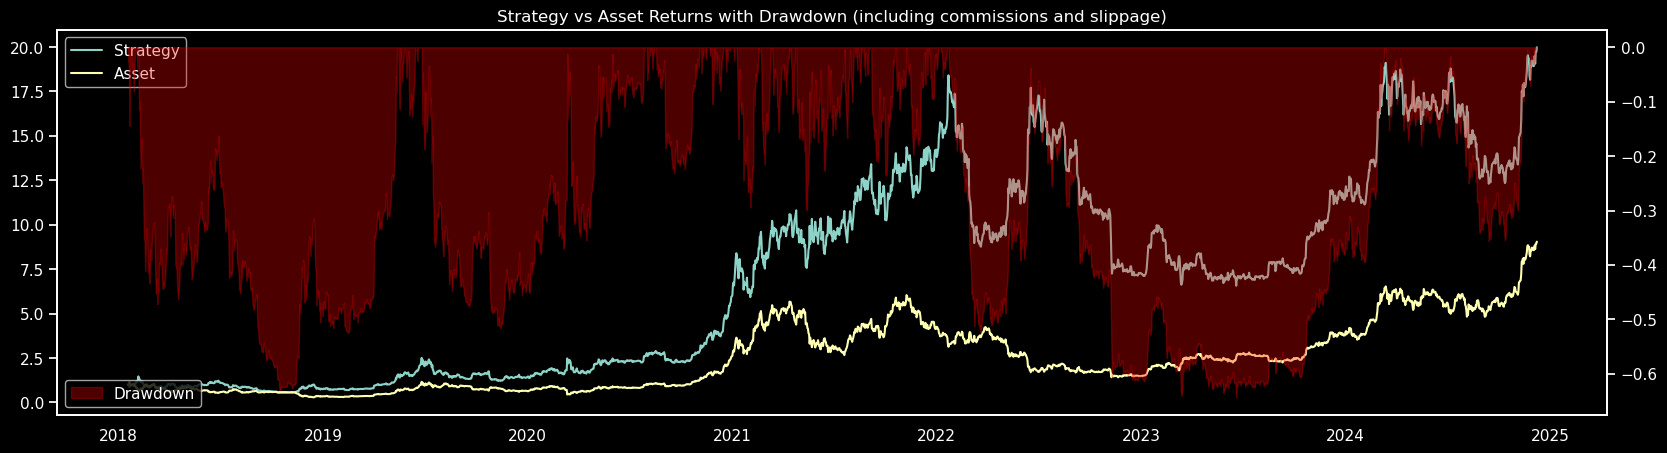

In [81]:
# Graficar el rendimiento de la estrategia frente al activo
fig, ax1 = plt.subplots()

# Graficar los rendimiento acumulados de la estrategia
ax1.plot(df.index, df['Cumulative_Returns'], label='Strategy')

#Graficar los rendimientos acumulados del activo directamente usando close
ax1.plot(df.index, (df['Close'] / df['Close'].iloc[0]), label='Asset')


# Gráficar el drawdown coloreando
ax2 = ax1.twinx()
ax2.fill_between(df.index, df['Drawdown'], 0 , color='red', alpha=0.3, label='Drawdown')

# Configurar leyendas y títulos
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
plt.title('Strategy vs Asset Returns with Drawdown (including commissions and slippage)')

plt.show()